# CSIT456 Lab 5: Decision Trees


## Name:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns


## About the data set
We are going to predict the survival of Titanic passagers using Decision Tree. 

The dataset has 891 examples and 11 features + 1 target variable. 2 of the features are floats, 5 are integers and 5 are objects. Here is the short descriiption of the featues:

1. PassengerId: Unique Id of a passenger. 
2. survival:    Survival. 0 is not survived and 1 is survived
3. pclass:    Ticket class     
4. Name: name of the passenger
5. sex:    Sex. 0 is male and 1 is female
6. Age:    Age in years     
7. sibsp:    # of siblings / spouses aboard the Titanic     
8. parch:    # of parents / children aboard the Titanic     
9. ticket:    Ticket number     
10. fare:    Passenger fare     
11. cabin:    Cabin number     
12. embarked:    Port of Embarkation

In [2]:
titanic = pd.read_csv("titanic.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data cleanup

We need to do some cleanup: 
 * age has missing values, let's say wherever we have no value, we assume that the person is of mean age (this is not necessarily a good decision)
 * embarked has missing values, we add a dedicated category for unknown embarkation points
 * we need to convert the categorical values to numerical values 

In [4]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].mean())

def sex_to_numeric(x):
    if x=='male':
        return 0
    if x=='female':
        return 1
    else:
        return x

titanic["Sex"] = titanic["Sex"].apply(sex_to_numeric)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# this will break if run more than once
def embarked_to_numeric(x):
    if x=="S":
        return 0
    if x=="C":
        return 1
    if x=="Q":
        return 2
    else: 
        return 3
    
titanic["Embarked"] = titanic["Embarked"].apply(embarked_to_numeric)
titanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.000000,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000000,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000000,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35.000000,0,0,373450,8.0500,NaN,0
5,6,0,3,"Moran, Mr. James",0,29.699118,0,0,330877,8.4583,NaN,2
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.000000,0,0,17463,51.8625,E46,0
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.000000,3,1,349909,21.0750,NaN,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.000000,0,2,347742,11.1333,NaN,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.000000,1,0,237736,30.0708,NaN,1


Let's work only with the numerical and categorical variables and omit passengerID, Name, Ticket and Cabin. These values could contain some information, but it's hard to make sense of them without more context.

In [6]:
features = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
titanic = titanic[features]
titanic.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.000000,1,0,7.2500,0
1,1,1,1,38.000000,1,0,71.2833,1
2,1,3,1,26.000000,0,0,7.9250,0
3,1,1,1,35.000000,1,0,53.1000,0
4,0,3,0,35.000000,0,0,8.0500,0
5,0,3,0,29.699118,0,0,8.4583,2
6,0,1,0,54.000000,0,0,51.8625,0
7,0,3,0,2.000000,3,1,21.0750,0
8,1,3,1,27.000000,0,2,11.1333,0
9,1,2,1,14.000000,1,0,30.0708,1


In [7]:
X = titanic.loc[:,"Pclass":"Embarked"].values
y = titanic["Survived"].values.reshape(-1,1)

Now let's look at a decision tree that **ONLY operates on sex**! 

In [8]:
from sklearn.model_selection import train_test_split

sex = titanic["Sex"].values.reshape(-1,1)
sex_train, sex_test, y_train, y_test = train_test_split(sex, y, random_state=0)

In [9]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
tree_oneFeature = DecisionTreeClassifier()
tree_oneFeature.fit(sex_train, y_train)

DecisionTreeClassifier()

In [10]:
tree_onFeature_dot = export_graphviz(tree_oneFeature, out_file=None, feature_names=["sex"])
tree_onFeature_dot

'digraph Tree {\nnode [shape=box] ;\n0 [label="sex <= 0.5\\ngini = 0.474\\nsamples = 668\\nvalue = [410, 258]"] ;\n1 [label="gini = 0.311\\nsamples = 437\\nvalue = [353, 84]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="gini = 0.372\\nsamples = 231\\nvalue = [57, 174]"] ;\n0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n}'

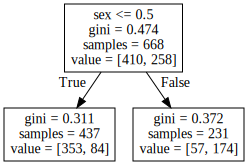

In [11]:
import graphviz
graphviz.Source(tree_onFeature_dot)

In [12]:
tree_oneFeature.score(sex_test,y_test)

0.7802690582959642

The accuracy is 78% when we just consider one feature. It's a good start. Now, let's try all the features in X.


## Question 1 [5 points] Data Preparing
**X** is the array of features and **y** is the one of predictor variable.

Split the data to train set (70%) and test set (30%) and don't allow the random selection. 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

## Question 2 [30 points] Create a Decision Tree with at most 3 depth
1. Create a decision tree and set the maximum depth to 3 [5 points]
2. Train the tree by the training set [5 points]
3. Plot the tree [15 points]
4. Caclulate the test accurancy of the tree [5 points]

In [14]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

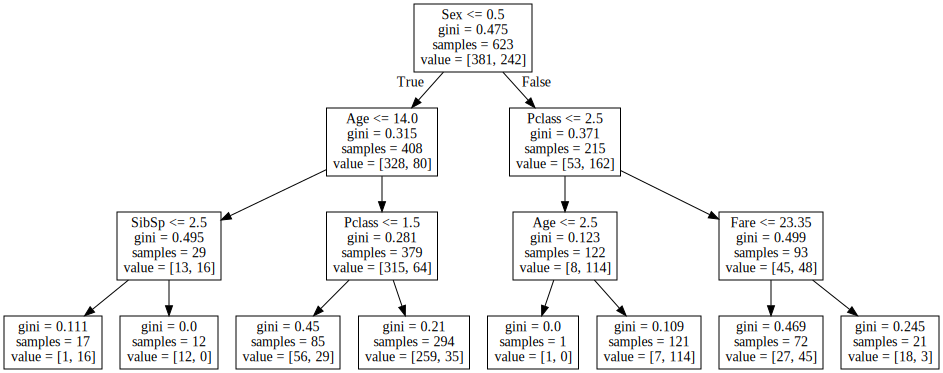

In [15]:
tree_all_features = export_graphviz(tree, out_file=None, feature_names=features[1:])
graphviz.Source(tree_all_features)

In [16]:
tree.score(X_test,y_test)

0.8208955223880597

## Question 3 [15 points] Tunning the hyperparameter 
1. Apply GridSearchCV to find the best value of *max_leaf_nodes* from 2 to 19 using 10-fold CV and set the random state to 0. [5 points]
2. Print the best value of *max_leaf_nodes* and the test accurancy with the best value. [5 points]
3. Plot the tree and describe your observation. [5 points]|

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

param_grid = {'max_leaf_nodes': range(2,20)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=10, return_train_score=True)
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_leaf_nodes': range(2, 20)},
             return_train_score=True)

In [18]:
best_tree_cv = grid.best_estimator_
best_tree_cv_plot = export_graphviz(best_tree_cv, out_file=None, feature_names=features[1:])
grid.best_params_

{'max_leaf_nodes': 15}

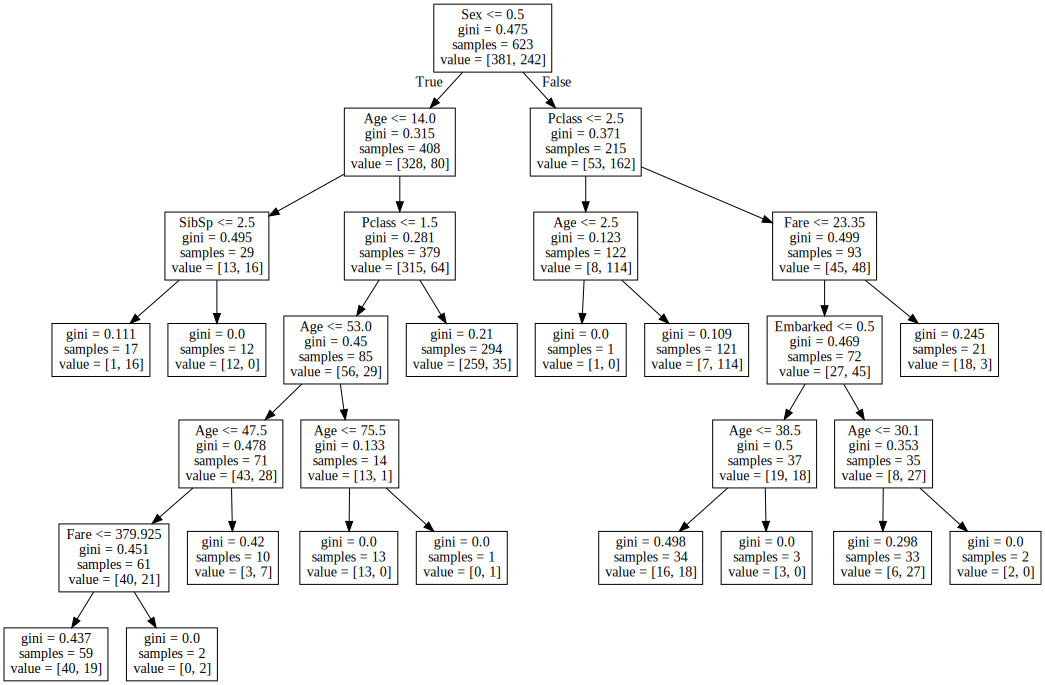

In [19]:
graphviz.Source(best_tree_cv_plot)

    To interpret how this tree works, it starts with the most important factor when determining whether someone survived the titanic or not: whether they're male or female. This is done via the CART (Classiifcation And Regression Tree) Algorithm to choose which features should be displayed by the tree and where they should be displayed, guided by our grid search which found that the best maximum number of leaf nodes to display is 8. Since the root node is sex, it means that the sex of someone is one of the most important factors when determining whether someone survived the titanic or not. After sex comes other important factors that determine the survival chances of someone on the titanic, based on whether they are male or female. While not every single traversal will be covered, the root traversal will be extensively covered alongside small discussion about others. 
    To observe the root tree, whether someone is male and female, we get four arguments: sex, gini, samples, and value. The easiest ones to describe are samples and value, with samples being the number of samples that are being fed into the tree, in this case being 623. Value is [381, 242], which is the samples being split up into two numbers, with 381 being passangers who died on the Titanic and 242 passangers surviving. The next number is the Gini coefficient, which is how likely is for the model to take a new prediction and predict it incorrectly. The gini coefficient for simply predicting survivors is 0.475, meaning by simply making a guess, the model can have a 47.5% chance of making an incorrect prediction. The final argument, sex <= 0.5, is a boolean argument that lets us begin traversing the tree. If sex <= 0.5, then the sex is 0, meaning that the person is male, and when this statement is true, we begin traversing the left side of the tree. If sex > 0.5, then the sex is 1, meaning that the person is female and the statement is false, we traverse the right side of the tree. 
    As the tree traversal continues, you find different paths based on categorical splits like age, class, fare, and embarked station. This gives us more accurate representation of who survived. For example, 162 females survived while 53 died, and the model can make an accurate prediction of women survivorship with only a 37.5% error rate. However, of the females who were second class and first class, 114 survivied and 8 died, meaning that the model can predict survivorship of second class and first class women with only a 12.3% error rate, meaning 87.7% accurate. 
    Looking at the tree as a whole, the best chances of someone surviving the titanic is being a woman and those chances can be boosted if it is a women of second class and first class, because women of third class was more like a flip of the coin. They can survive if they're a woman of third class if their fare was less than 23.33 and they embarked from any port other than port S, otherwise their chances are either closer to a coin flip, or if their fare is greater than 23.33, basically gaurenteed to die. As for the men, this is the opposite story, as you're more likely to die on the titanic if you're a man and the only saving grace that men have is that if they have two siblings or spouses on the board, then their chances of survival go up dramatically at 88.9%, and the model reflects that with its predictions. Otherwise, if you're a man, you're more than likely screwed

In [20]:
grid.score(X_test,y_test)

0.8208955223880597